In [1]:
# A notebook to evaluate GNN explainer performance by calculating Comprehensiveness and Sufficiency 
#     as defined in "BAGEL: A Benchmark for Assessing Graph Neural Network Explanations", by Rathee et al. (2022). 
# 
#     Model training and explanation generation adapted from the original MolRep code by Tim Stols.


In [2]:
# Converted by Tim Stols
# python Explainer_Experiments.py --model_name CMPNN \
#                                                        --attribution_name GradInput \
#                                                        --data_path ../MolRep/Datasets/Metabolism/admet2.1_rlm_merge.csv \
#                                                        --dataset_name RLM \
#                                                        --smiles_col COMPOUND_SMILES \
#                                                        --target_col CLF_LABEL \
#                                                        --task_type Multi-Classification \
#                                                        --multiclass_num_classes 3 \
#                                                        --output_dir ../Outputs

In [3]:
import gc
import os

from pathlib import Path

LOADING_FROM_FILES = True # True if loading in data from pre-existing files
SAMPLE_SIZE = 600 # [0, 2400), for how many molecules comprehensiveness and sufficiency is calculated per explainer 

# output directory for trained model and explanations
OUTPUT_DIR = f'../Outputs/Experiment'
# OUTPUT_DIR = '../Outputs' # original output path, overwrites results

# output the explanations (optionally model) here
output_dir = Path(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

DATASET = 'Benzene'
# DATASET = '3MR'

# GNN
MODEL = 'CMPNN' # Options:  ['MPNN', 'DMPNN', 'CMPNN', 'GIN', 'ECC', 'GAT', 'DGCNN', 'DiffPool', 'GraphSAGE', 'GraphNet']

# use specified model, else train a new one
# MODELPATH = None
MODELPATH = '../Outputs/Experiment/CMPNN_Benzene_explainer/CMPNN_1_epoch.pt' # using this model because it has non-zero F1 score
# MODELPATH = '../Models/CMPNN_3MR_explainer_20240519_143138.pt'

if MODELPATH is None:
    MODELPATH = os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer", f"{MODEL}.pt")

# explainers used on the trained model, overwritten down below for testing purposes
ATTRIBUTIONS = ['IG', 'GradCAM', 'Random'] # Options: IG CAM MCTS GradInput GradCAM RandomBaseline # this says RandomBaseLine but code expects 'Random'

DATAPATH = '../Datasets/XAI/Benzene/benzene_smiles.csv'
# DATAPATH = '../DataSets/3MR/toy_label_mw350.csv'
SMILESCOL = 'SMILES'
TARGETCOL = 'label'
# TARGETCOL = 'label_full' # for 3MR, on my machine the functions targets the wrong label, even if the offending column is deleted

ATTRIBUTIONPATH = '../Datasets/XAI/Benzene/attributions.npz'
# ATTRIBUTIONPATH = '../DataSets/3MR/attributions.npz'


TASKTYPE = 'Classification' # Can be 'Multi-Classification', 'Classification', 'Regression'
MULTICLASS_NUM_CLASSES = 2 # Can be 3
TESTING = True
SPLITTYPE = 'defined' # Can be 'random', 'scaffold', or other defined for dataset


In [4]:
import rdkit.Chem
from MolRep.Utils.logger import Logger
from MolRep.Explainer.explainerExperiments import ExplainerExperiments
from MolRep.Explainer.explainerDataWrapper import ExplainerDatasetWrapper
from MolRep.Utils.config_from_dict import Grid, Config, DatasetConfig
from pathlib import Path
import os
# from numba.cuda import args

# torch.set_num_threads(1)

# set up the model
data_stats = {
            'name': DATASET,
            'path': DATAPATH,
            'smiles_column': SMILESCOL,
            'target_columns': [TARGETCOL],
            'attribution_path': ATTRIBUTIONPATH,
            'task_type': TASKTYPE,
            'multiclass_num_classes': MULTICLASS_NUM_CLASSES,
            'metric_type': 'rmse' if TASKTYPE == 'Regression' else ['acc', 'auc', 'f1', 'precision', 'recall'],
            'split_type': SPLITTYPE
}

if TESTING:
    data_stats['additional_info'] = {"splits":'SPLIT'}
    
# output for vector groups
data_dir = Path('../MolRep/Data')
split_dir = Path('../MolRep/Splits')
os.makedirs(data_dir, exist_ok=True)
os.makedirs(split_dir, exist_ok=True)

In [5]:
config_file = '../MolRep/Configs/config_{}.yml'.format(MODEL)
model_configurations = Grid(config_file)
model_configuration = Config(**model_configurations[0])
dataset_configuration = DatasetConfig(DATASET, data_dict=data_stats)

CMPNN
{'GIN': <class 'MolRep.Models.graph_based.GIN.GIN'>, 'ECC': <class 'MolRep.Models.graph_based.ECC.ECC'>, 'DGCNN': <class 'MolRep.Models.graph_based.DGCNN.DGCNN'>, 'DiffPool': <class 'MolRep.Models.graph_based.DiffPool.DiffPool'>, 'GraphSAGE': <class 'MolRep.Models.graph_based.GraphSAGE.GraphSAGE'>, 'GAT': <class 'MolRep.Models.graph_based.GAT.GAT'>, 'GraphNet': <class 'MolRep.Models.graph_based.GraphNet.GraphNet'>, 'MPNN': <class 'MolRep.Models.graph_based.MPNN.MPNN'>, 'CMPNN': <class 'MolRep.Models.graph_based.CMPNN.CMPNN'>, 'DMPNN': <class 'MolRep.Models.graph_based.DMPNN.DMPNN'>, 'MAT': <class 'MolRep.Models.sequence_based.MAT.MAT'>, 'CoMPT': <class 'MolRep.Models.sequence_based.CoMPT.CoMPT'>, 'BiLSTM': <class 'MolRep.Models.sequence_based.BiLSTM.BiLSTM'>, 'SALSTM': <class 'MolRep.Models.sequence_based.SALSTM.SALSTM'>, 'Transformer': <class 'MolRep.Models.sequence_based.Transformer.Transformer'>, 'VAE': <class 'MolRep.Models.unsupervised_based.VAE.VAE'>, 'RandomForest': <class

In [6]:
# export path: model + dataset name
exp_path = os.path.join(output_dir, f'{model_configuration.exp_name}_{dataset_configuration.exp_name}_explainer')

# dataset_config: configuration of the model
# model_name: name of the model
# split_dir: path to defined splits of the dataset
# features_dir: path to data directory
dataset = ExplainerDatasetWrapper(dataset_config=dataset_configuration,
                                  model_name=model_configuration.exp_name,
                                  split_dir=split_dir, features_dir=data_dir)

# set up the experiment
explainer_experiment = ExplainerExperiments(model_configuration, dataset_configuration, exp_path)

In [7]:
import pandas as pd
import re
# import torch

# to load a model from a file without having used it, need to instantiate it first
# model = CMPNN(model_configuration)
# state_dict = torch.load(MODELPATH)
# model.load_state_dict(state_dict)

# Options: IG CAM MCTS GradInput GradCAM RandomBaseline # says RandomBaseLine but code expects 'Random'
ATTRIBUTIONS = []

atom_importances = []
explainer_accuracies = []

if LOADING_FROM_FILES :
    LOGGER_BASE = os.path.join(OUTPUT_DIR, "Logger", f"{DATASET}_explainer")
    logger = Logger(str(os.path.join(LOGGER_BASE, f"{MODEL}_{DATASET}_explainer_by_experiment.log")), mode='a')
    
    ### TODO on first run, uncomment, on subsequent runs can leave commented out ###
    # _, _, _ = explainer_experiment.molecule_importance(dataset=dataset, attribution=ATTRIBUTIONS[0], logger=logger, other={'model_path':MODELPATH}, testing=TESTING)
    
    # read in used explainers
    explainer_accs_path = os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer" , f"explainer_accuracies.csv")
    explainer_accuracies_df = pd.read_csv(explainer_accs_path) # used for looking at, nothing else
    
    for e in explainer_accuracies_df['explainer']:
        ATTRIBUTIONS.append(e)
    
    # get atom importances per explainer
    for ATTRIBUTION in ATTRIBUTIONS:
        atom_imp_for_expl = []
        
        imp_path = os.path.join(output_dir, f"{MODEL}_{DATASET}_explainer", "SVG", f"{ATTRIBUTION}_{model_configuration['num_epochs']}_epochs" , "importances.csv")

        # atom importances are given as a string of an array of floats 
        importance = pd.read_csv(imp_path)['Atom_importance']
        
        for _, row in importance.items():
            # remove brackets and newlines
            clean_imp = re.sub(r'[\[\]\n]', '', row).strip()
            
            # split by whitespace and convert to float
            float_imps = [float(x) for x in clean_imp.split()]
            atom_imp_for_expl.append(float_imps)

        atom_importances.append(atom_imp_for_expl)    
    
else: 
    ATTRIBUTIONS = ['IG', 'GradCAM', 'Random']
    # generate explanations for each explainer
    for ATTRIBUTION in ATTRIBUTIONS:
        LOGGER_BASE = os.path.join(OUTPUT_DIR, "Logger", f"{DATASET}_explainer")
        logger = Logger(str(os.path.join(LOGGER_BASE, f"{MODEL}_{DATASET}_explainer_by_{ATTRIBUTION}.log")), mode='a')
        
        # define path for graphics
        svg_dir = os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer", "SVG", f"{ATTRIBUTION}_{model_configuration['num_epochs']}_epochs")
        os.makedirs(svg_dir, exist_ok=True)
    
        ### comment out if a model exists and want to use it with all models, else trains a new one for each ###
        # explainer_experiment.run_valid(dataset, ATTRIBUTION, logger=logger, other={'model_path':MODELPATH})
    
        ## if model doesn't exist, train a new one
        # if not os.path.exists(MODELPATH):
        #     explainer_experiment.run_valid(dataset, ATTRIBUTION, logger=logger, other={'model_path':MODELPATH})
        
        # generate attributions; bond_importance is None in all the tests I ran
        results, atom_importance, bond_importance = explainer_experiment.molecule_importance(dataset=dataset, attribution=ATTRIBUTION, logger=logger, other={'model_path':MODELPATH}, testing=TESTING)
        
        if DATASET in ['hERG', 'CYP3A4']:
            attribution_results, opt_threshold = explainer_experiment.evaluate_cliffs(dataset, atom_importance, bond_importance)
        else:
            binary = True if ATTRIBUTION == 'MCTS' else False
            #TODO "not working, because ATTRIBUTIONPATH is not set and attributions are not saved"
            attribution_results, opt_threshold = explainer_experiment.evaluate_attributions(dataset, atom_importance, bond_importance, binary=binary)
         
        # creates visualizations from the datasets and outputs them to svg_dir
        explainer_experiment.visualization(dataset, atom_importance, bond_importance, svg_dir=svg_dir, testing=TESTING)
    
        # write the results, atom importances to a file
        df = pd.DataFrame(
            {'SMILES': dataset.get_smiles_list(), 'Atom_importance': atom_importance, 'Bond_importance':bond_importance}
        )
        df.to_csv(os.path.join(svg_dir, "importances.csv"), index=False)
    
        # create an object from the pre-established metrics, add to list (include model results to ensure they're all the same)
        acc = {"explainer" : ATTRIBUTION,
               "model" : MODEL,
                "epochs" : model_configuration['num_epochs'],
                "acc" : results['acc'],
                "auc" : results['auc'], 
                "f1" : results['f1'], 
                "precision" : results['precision'], 
                "recall" : results['recall'], 
                "Attribution AUROC" : attribution_results['Attribution AUROC'], 
                "Attribution F1" : attribution_results['Attribution F1'], 
                "Attribution ACC" : attribution_results['Attribution ACC'], 
                "Attribution Precision" : attribution_results['Attribution Precision'], 
                "Attribution AUROC Mean" : attribution_results['Attribution AUROC Mean'], 
                "Attribution ACC Mean" : attribution_results['Attribution ACC Mean'] }
        explainer_accuracies.append(acc)
    
        # add atom importances to a list, fetch them by index of attributions on the list used
        # importance = {"Atom_importance" : atom_importance}
        atom_importances.append(atom_importance)
       
    # TODO store these in a file
    explainer_accuracies_df = pd.DataFrame(explainer_accuracies)
    
    # dataframe for storing atom importances per explainer in a file later
    importances_df = pd.DataFrame(atom_importances)

In [8]:
import copy

# path to model and explanations

x = os.path.join(output_dir, f"{MODEL}_{DATASET}_explainer", "SVG", f"IG_{model_configuration['num_epochs']}_epochs" , "importances.csv")
# IMPORTANCES_PATH = '../Outputs/20240524_164403/CMPNN_Benzene_explainer/SVG/IG_1_epochs/importances.csv' 

# os.path.join(output_dir, f"{MODEL}_{DATASET}_explainer", "SVG", f"{ATTRIBUTION}_{DATASET}_explainer" , "importances.csv")
IMPORTANCES_PATH = x


# svg_dir = os.path.join(OUTPUT_DIR, f"{MODEL}_{DATASET}_explainer", "SVG", f"{ATTRIBUTION}_{model_configuration['num_epochs']}_epochs")
# df.to_csv(os.path.join(svg_dir, ), index=False)

# df = pd.read_csv(IMPORTANCES_PATH)
# print(df['Atom_importance'].iat[3])

# TODO write explainer_accuracies and atom importances to a file if they arent already

# y = os.path.join(output_dir, f"{MODEL}_{DATASET}_explainer", f"{model_configuration['num_epochs']}_epochs")
# os.makedirs(y, exist_ok=True)

# df.to_csv(os.path.join(svg_dir, "importances.csv"), index=False)

# explainer_accuracies_df.to_csv(y, "explainer_accuracies.csv", index=False)
explainer_accuracies_df

,explainer,model,epochs,acc,auc,f1,precision,recall,Attribution AUROC,Attribution F1,Attribution ACC,Attribution Precision,Attribution AUROC Mean,Attribution ACC Mean
0,IG,CMPNN,1,0.7475,0.84503,0.772693,0.707904,0.850537,0.948258,0.270941,0.826335,0.409868,0.902073,0.822777
1,GradCAM,CMPNN,1,0.7475,0.84503,0.772693,0.707904,0.850537,0.946488,0.232464,0.816451,0.386729,0.894481,0.811813
2,Random,CMPNN,1,0.7475,0.84503,0.772693,0.707904,0.850537,0.502484,0.000000,0.815321,0.000000,0.501554,0.804673


In [9]:
import numpy as np
def convert_from_test_to_real_idx(idx):
    """Converts the index used in the test set to the index in the whole dataset."""    
    smile = dataset.get_smiles_list(testing=True)[idx]
    
    data = dataset.whole_data_df 
    return data.loc[(data == smile).any(axis=1)].index[0]

def convert_real_idx_to_test_idx(idx):
    """Converts an index from the big dataset to the one in the test set"""
    ds = dataset.whole_data_df 
    ts = dataset.get_smiles_list()
    smile = ds.iloc[idx]['SMILES']

    return np.where(ts == smile)[0][0]

In [10]:
p = convert_real_idx_to_test_idx(11998)
print(p)
c = convert_from_test_to_real_idx(2399)
print(c)

2399
11998


In [11]:
def split_molecule(mol_idx:int, explainer='IG', threshold=1e-4, from_whole_data=False, strict_split=False):
    """Splits the given molecule into explaining and non-explaining SMILES based on given explanation, returns those and the SMILES of the molecule. Threshold value is the same as in explainerExperiments.py visualization(). from_whole_data True if using idx in the whole dataset, False if looking by index in test set"""
    
    if from_whole_data:
        smile = dataset.whole_data_df.SMILES.iat[mol_idx]
        mol_idx = convert_real_idx_to_test_idx(mol_idx)
    else:
        # testing = True by default
        smile = dataset.get_smiles_list(testing=True)[mol_idx]
    
    # atom importances depend on what explainer method is used, mol_idx is convenient
    expl_idx = ATTRIBUTIONS.index(explainer)
    a_importances = atom_importances[expl_idx][mol_idx]

    original_mol = rdkit.Chem.RWMol(rdkit.Chem.MolFromSmiles(smile))
     
    explaining_atom_idxs = []
    expl_edge_atom_idxs = []
    non_explaining_atom_idxs = []
    
    for idx in range(len(original_mol.GetAtoms())):
        if a_importances[idx] < threshold:
            non_explaining_atom_idxs.append(idx)
        else:
            explaining_atom_idxs.append(idx)
    
    # reverse because removing atoms causes indices of others to shift
    non_explaining_atom_idxs.reverse()
    explaining_atom_idxs.reverse()
    
    # number of atoms in explanation vs whole molecule 
    exp_length = len(explaining_atom_idxs) / ( len(explaining_atom_idxs) + len(non_explaining_atom_idxs))
    
    explaining_bonds = []
    non_explaining_bonds = []
    
    for bond in original_mol.GetBonds():
        start = bond.GetBeginAtomIdx()
        end = bond.GetEndAtomIdx()
        
        # if an explaining atom connects to a nonexplaining atom, it's an edge atom
        if start not in explaining_atom_idxs and end in explaining_atom_idxs:
            expl_edge_atom_idxs.append(end)
                
        if end not in explaining_atom_idxs and start in explaining_atom_idxs:
            expl_edge_atom_idxs.append(start)
        
        # if both end and start in explaining atoms, the edge is explaining 
        if start in explaining_atom_idxs and end in explaining_atom_idxs:
            explaining_bonds.append((start, end))
        else:
            # non explaining bond found
            non_explaining_bonds.append((start, end))
             
    expl_edge_atom_idxs = list(set(expl_edge_atom_idxs))
    
    # print("expl ", explaining_atom_idxs)
    # print("edge ", expl_edge_atom_idxs)
    # print("non ", non_explaining_atom_idxs )
     
    # explaining molecule has non-explaining bonds and atoms removed
    explaining_mol = copy.deepcopy(original_mol)
    for (i, j) in non_explaining_bonds:
        # print(i, j)
        explaining_mol.RemoveBond(i, j)
        explaining_mol.RemoveBond(j, i)
    
    for idx in non_explaining_atom_idxs:
        explaining_mol.RemoveAtom(idx)

    explaining_smile = rdkit.Chem.MolToSmiles(explaining_mol)
    
    # non-explaining molecule removes explaining bonds and atoms not on the edge of the explanation 
    non_explaining_mol = copy.deepcopy(original_mol)    
    
    # remove explaining bonds 
    for (i, j) in explaining_bonds:
        non_explaining_mol.RemoveBond(i, j)
        non_explaining_mol.RemoveBond(j, i)

    # if strict_split false, leads to situations where nonexplaining fragments can be connected by one explaining atom e.g. mol 93
    if strict_split:
        for i in [e for e in explaining_atom_idxs]:
            non_explaining_mol.RemoveAtom(i)    
    else:
        for i in [e for e in explaining_atom_idxs if e not in expl_edge_atom_idxs]:
            non_explaining_mol.RemoveAtom(i)
    
    non_explaining_smile = rdkit.Chem.MolToSmiles(non_explaining_mol)
    
    return smile, explaining_smile, non_explaining_smile, exp_length

In [12]:
s, e, n, m = split_molecule(128, from_whole_data=False, strict_split=False)
s1, e1, n1, m1 = split_molecule(128, from_whole_data=False, strict_split=True)

from rdkit import Chem
from rdkit.Chem import Draw
# 168
print(s)
print(e, "\t", e1)
print(n, "\t", n1)

COc1ccc2cc(ccc2c1)c1cc(ccn1)C(=O)[O-]
ccc(cc-c1ccc2ccccc2c1)C(=O)[O-] 	 ccc(cc-c1ccc2ccccc2c1)C(=O)[O-]
COc.cnc 	 CO.n


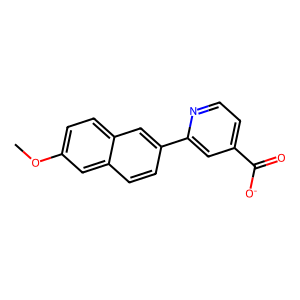

In [13]:
Draw.MolToImage(Chem.MolFromSmiles(s))
# Draw.MolToImage(Chem.MolFromSmiles(e1))
# Draw.MolToImage(Chem.MolFromSmiles(n))
# print(ATTRIBUTION) c1nccN1

In [14]:
# Draw.MolToImage(Chem.MolFromSmiles(n))
# 17 => 93.png

In [15]:
import torch
from MolRep.Featurization.MPNN_embeddings import MolGraph, BatchMolGraph
from rdkit.Chem import MolFromSmiles, rdmolops

def tensors_to_device(smile, batch):
    """Sets nodes, edges, a2b, b2a and adjacency matrix tensors of a molecule to the device"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    adj = rdmolops.GetAdjacencyMatrix(MolFromSmiles(smile))
    
    features = {
        'nodes' : batch.f_atoms, 
        'edges' : batch.f_bonds,
        'a2b' : batch.a2b,
        'b2a' : batch.b2a,
        'adjacency' : torch.FloatTensor(adj) 
    }
    
    for i in features:
        features[i].to(device)
        
    return features['nodes'], features['edges'], features['a2b'], features['b2a'], features['adjacency']

In [16]:
import re
def clean_smile(smile:str) -> str:
    """Takes a (fragmented) SMILES as input and returns concatenated valid fragments of it. Does nothing if input is already valid.
    e.g: C.CC.F.O.n.n -> C.CC.F.O
    """
    cs = ""
    # 1. split n/explanations into a list
    subm = smile.split('.')
    
    # 2. try to convert the pieces into a molgraph
    # if success, append to a new string cs (cut string)
    for (i, sm) in enumerate(subm): 
        try:
            MolGraph(sm)
            cs += sm
            cs += '.'
        except:
            cs += '.'
            continue

    # remove repetitions and the first and last period from the string
    cs = re.sub("\.+", ".", cs)
    # ReGeX from https://stackoverflow.com/a/3331982
    cs = re.sub("\.([^.]*)$", "", cs)
    cs = re.sub("(^\.)", "", cs)
    return cs

In [17]:
def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

EXPERIMENT_MODEL = MODELPATH

In [18]:
def comp_and_suff(idx, explainer = 'IG', from_all_data=False, modified_formula=True, strict_split=False) :
    """Calculates comprehensiveness and sufficiency for a molecule with index idx, given explanation e, returns an object with mol_idx, all the smiles (cleaned and uncleaned), predictions for everything, comprehensiveness and sufficiency, and proportion of explanation vs original molecule. from_all_data True if fetching smile from the whole set, False if from test set."""
    
    # TODO move this out so no need to get the same model every time
    model = explainer_experiment.get_model(dataset, other={'model_path':EXPERIMENT_MODEL})
    model.eval() # set model to evaluation mode

    smile, explaining_smile, non_explaining_smile, exp_length = split_molecule(idx, explainer, from_whole_data=from_all_data, strict_split=strict_split)
    
    # clean up the smiles, split may have created invalid molecules
    clean_smiles = list(map(clean_smile, [smile, explaining_smile, non_explaining_smile]))

    preds = []
    for (i, cs) in enumerate(clean_smiles):
        if cs == "": # don't predict empty strings
            # if no non-explaining, then comp is f(g) = great, because the whole molecule explains the prediction!
            # if no explaining, suff is f(g) = maybe good?, because there's nothing to explain why prediction was made?
            
            # none to predict to begin with != none being valid
            if cs == [smile, explaining_smile, non_explaining_smile][i]:
                preds.append([0]) # no (non)explaining to begin with is a-okay     
            else:
                preds.append([None]) # no valid strings after cleaning up less so
            continue
            
        subpreds = []
        
        if modified_formula:
            splits = cs.split('.')
            for split in splits:
            
                # 3. convert s to molgraph
                try:
                    mol = MolGraph(split)
                    g_input = BatchMolGraph( [mol])
                    atoms, bonds, a2b, b2a, adjacency = tensors_to_device(cs, g_input)
            
                    with torch.no_grad():
                        # TODO investigate None params?
                        #   Args for mol2graph:
                        # - mols: A list of SMILES or a list of RDKit molecules.
                        # - atom_descriptors_batch: A list of 2D numpy array containing additional atom descriptors to featurize the molecule
                        subpred = model([[split], None, None]).item()
            
                    subpreds.append(subpred)
                except:
                    # If model couldn't predict the subgraph for whatever weird reason
                    # I don't know why this would happen, but evidently it does happen
                    subpreds.append(None)
        else:
            try:
                mol = MolGraph(cs)
                g_input = BatchMolGraph( [mol])
                atoms, bonds, a2b, b2a, adjacency = tensors_to_device(cs, g_input)
        
                with torch.no_grad():
                    # TODO investigate None params?
                    #   Args for mol2graph:
                    # - mols: A list of SMILES or a list of RDKit molecules.
                    # - atom_descriptors_batch: A list of 2D numpy array containing additional atom descriptors to featurize the molecule
                    subpred = model([[cs], None, None]).item()
        
                subpreds.append(subpred)
            except:
                # If model couldn't predict the subgraph for whatever weird reason
                # I don't know why this would happen, but evidently it does happen
                subpreds.append(None)
            
        preds.append(subpreds)
    
    converted_idx = idx
    if not from_all_data:
        converted_idx = convert_from_test_to_real_idx(idx)
    
    try:
        mol_pred = preds[0][0] # prediction of original molecule, there is only one so do nothing
        
        if modified_formula: 
            e_pred = None if preds[1] == [None] else sum(preds[1]) / len(preds[1]) # prediction of explaining molecules : take the mean
            n_pred = None if preds[2] == [None] else sum(preds[2]) # prediction of non-explaining molecules : sum
        else:
            e_pred = None if preds[1] == [None] else preds[1][0]
            n_pred = None if preds[2] == [None] else preds[2][0]
        
        # f = model prediction given a smile
        # comp = f(smile) - f(non_explaining_smile)
        # suff = f (smile) - f(explaining_smile)
        
        comp = mol_pred - n_pred if n_pred is not None else None
        suff = mol_pred - e_pred if e_pred is not None else None
        
        result = {
            "explainer" : explainer,
            "mol_idx": idx if from_all_data else converted_idx,
            "smile" : smile,
            "explaining_smile" : explaining_smile,
            "clean_explanation" : clean_smiles[1],
            "non_explaining_smile" : non_explaining_smile,
            "clean_nonexplanation": clean_smiles[2],
            "mol_pred": mol_pred,
            "e_pred": e_pred,
            "ne_pred": n_pred,
            "comp" : comp,
            "suff" : suff,
            "expl length": exp_length
        }
        
        return result
    except:
        # print 
        print(preds, " idx in dataset: ", converted_idx , " idx in test set: ", idx)


In [19]:
def comp_suff_all_variations(idx):
    van_strict = comp_and_suff(idx, modified_formula=False, from_all_data=True, strict_split=True)
    van_soft = comp_and_suff(idx, modified_formula=False, from_all_data=True, strict_split=False)
    mod_strict = comp_and_suff(idx, from_all_data=True, strict_split=True)
    mod_soft = comp_and_suff(idx, from_all_data=True, strict_split=False)
    
    return pd.DataFrame([van_strict, van_soft, mod_strict, mod_soft])

In [20]:
# c = comp_suff_all_variations(168)
# d = comp_suff_all_variations(238)

In [21]:
# e = comp_suff_all_variations(11997)

# 1018 has two rings, 509 has one, so does 168
# 
# van_1018_strict = comp_and_suff(1018, modified_formula=False, from_all_data=True, strict_split=True)
# van_1018_soft = comp_and_suff(1018, modified_formula=False, from_all_data=True, strict_split=False)
# mod_1018_strict = comp_and_suff(1018, from_all_data=True, strict_split=True)
# mod_1018_soft = comp_and_suff(1018, from_all_data=True, strict_split=False)
# print(split_molecule(3, from_whole_data=False)) # mol idx is number 3 in test set i.e. mol 13
# print(split_molecule(3, from_whole_data=True)) # mol idx is number 3 in whole set
# Draw.MolToImage()

In [22]:
# c # 168
# print(van_3)
# print(mod_3)

In [23]:
# d # 238

In [24]:
# e # 1018

In [25]:
def get_samples():
    """If a sample file doesn't exist, create new samples and save to file, else read from a file."""
    try:
        samples = pd.read_csv(os.path.join(exp_path, 'samples.csv'))
        return samples.to_numpy().flatten()
    except:
        samples = np.random.choice(len(dataset.get_smiles_list(testing=True)), SAMPLE_SIZE, replace=False)
        samples = np.sort(samples, axis=0)
        samples_df = pd.DataFrame(samples)
        samples_df.to_csv(os.path.join(exp_path, 'samples.csv'), header=True, index=False)
        return samples

SAMPLES = get_samples()

In [26]:
def comp_and_suff_data(explainer='IG', sample_size=SAMPLE_SIZE, random_samples=False):
    """Accumulates the comp and suff for molecules within the test set of the provided dataset. Random_samples True if using pre-generated random samples, else iterates molecules in order."""
    c_and_s = []
    
    n = min(SAMPLE_SIZE, len(dataset.get_smiles_idxs(testing=True)))
    
    # if using random samples, iterate through them
    if random_samples:
        for i in SAMPLES:
            torch.cuda.empty_cache() # please be enough to allow things to run smoothly
            vals = comp_and_suff(i, explainer)
            c_and_s.append(vals)     
    # we only care about the index, because we're getting things by index in the test set
    else:
        for i in range(n):
            torch.cuda.empty_cache() # please be enough to allow things to run smoothly
            vals = comp_and_suff(i, explainer)
            c_and_s.append(vals)
    return c_and_s


In [27]:

# c = comp_and_suff_data()
# pd.DataFrame(c)

In [28]:
# save results of comp-suff for transparency

def comp_and_suff_for_all_explainers(explainers, sample_size=SAMPLE_SIZE, random_samples=False):
    """Calculates comp and suff for all explainers, given a list of explainers and a full matrix of atom importances. Struggles with 3 explainers and higher number of samples, 100 and 200 are okay."""
    comps = []
    
    for (i, explainer) in enumerate(explainers):
        torch.cuda.empty_cache() # please be enough to allow things to run smoothly
        # print(i, explainer)
        
        if random_samples:
            comp = comp_and_suff_data(explainer=explainer, sample_size=sample_size, random_samples=True)
        else:
            comp = comp_and_suff_data(explainer=explainer, sample_size=sample_size, random_samples=False)
        
        comps.append(comp)
    return comps

In [29]:
# c_and_s = comp_and_suff_for_all_explainers(ATTRIBUTIONS, random_samples=True)

In [136]:
c_and_s = []
def read_comp_suff(attr):
    """Try to read comp and suff for given explainer from a file, else generate a new one."""
    p = os.path.join(exp_path, 'comps_suffs', f"{attr}_{SAMPLE_SIZE}_split_comp_and_suff.csv")
    try:
        c_and_s_expl = pd.read_csv(p)
        c_and_s.append(c_and_s_expl)
    except:
        c_and_s_expl = comp_and_suff_data(explainer=attr, random_samples=True)
        expl_df = pd.DataFrame(c_and_s_expl)
        c_and_s.append(expl_df)
        expl_df.to_csv(p, header=True, index=False)

In [137]:
clear_gpu_memory()
read_comp_suff('IG')

clear_gpu_memory()
read_comp_suff('GradCAM')

clear_gpu_memory()
read_comp_suff('Random')

In [138]:
c_and_s[0]

,explainer,mol_idx,smile,explaining_smile,clean_explanation,non_explaining_smile,clean_nonexplanation,mol_pred,e_pred,ne_pred,comp,suff,expl length
0,IG,18,CC[C@H](C)[C@H](C)NC(=O)NCc1ccnc(c1)OCC(F)(F)F,NC(N)=O.ccccc,NC(N)=O,CC[C@H](C)[C@H](C)N.cCN.cncOCC(F)(F)F,CC[C@H](C)[C@H](C)N,0.492734,0.490683,0.437377,0.055357,0.002051,0.391304
1,IG,34,Cc1cccc(c1)OCCn1c2cccc(c2[nH]c1=S)F,Oc1ccccc1.S=c1nc2ccccc2[nH]1,Oc1ccccc1,Cc.cF.nCCO,NaN,0.567857,0.578041,NaN,NaN,-0.010185,0.809524
2,IG,76,COc1cc(ccc1OCC(=O)Nc1ccccc1)C[NH2+]CCN,CNc1ccccc1.c1ccccc1,CNc1ccccc1.c1ccccc1,COc.cC[NH2+]CCN.cOCC=O,NaN,0.545822,0.576832,NaN,NaN,-0.031010,0.583333
3,IG,141,CC1=C2[C@@H](C(=C(O[C@H]2N=N1)N)C#N)[C@@H]1C=N...,C.C=C.C=CN.Cc1ccccc1,C.C=C.C=CN.Cc1ccccc1,CCN=N[C@@H](C[C@@H](CC#N)C1C=NN=C1)OC.cF,CCN=N[C@@H](C[C@@H](CC#N)C1C=NN=C1)OC,0.520875,0.506876,0.451052,0.069822,0.013999,0.520000
4,IG,245,C1CN(CC[C@@H]1C(=O)N)C(=O)[C@@H]1CC(=O)N(C1)C1...,C.CN.NC=O,C.CN.NC=O,CC1CCNCC1.O=C[C@@H]1CC(=O)N(C2CCOCC2)C1,CC1CCNCC1.O=C[C@@H]1CC(=O)N(C2CCOCC2)C1,0.446095,0.475107,0.876403,-0.430307,-0.029012,0.260870
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,IG,11841,C[C@@H]([C@H]1CCCO1)NC(=O)c1ccc(c(c1)OC)OCC(=O)N,C.NCc1ccccc1,C.NCc1ccccc1,C=O.C[C@H](N)[C@H]1CCCO1.cOC.cOCC(N)=O,C=O.C[C@H](N)[C@H]1CCCO1,0.504784,0.518930,0.907843,-0.403058,-0.014146,0.391304
596,IG,11842,Cc1cc(nc(c1C#N)S(=O)(=O)NC(C)(C)C)C,O.O.ccccc,O.O,Cc.CcncS(=O)(=O)NC(C)(C)C.cC#N,NaN,0.498860,0.470407,NaN,NaN,0.028452,0.388889
597,IG,11937,CC(=O)[C@@]12[C@@]3(CC[C@@H]4[C@@H]([C@@H]3C[C...,C.C=C,C.C=C,CC[C@H]1[C@H]([C@]2(C)CC[C@@H](O)CC2)CC[C@]2(C...,CC[C@H]1[C@H]([C@]2(C)CC[C@@H](O)CC2)CC[C@]2(C...,0.429738,0.477065,0.423673,0.006065,-0.047327,0.120000
598,IG,11980,C(COCCS)O,NaN,NaN,OCCOCCS,OCCOCCS,0.438459,0.000000,0.438263,0.000197,0.438459,0.000000


In [139]:
c_and_s[1]

,explainer,mol_idx,smile,explaining_smile,clean_explanation,non_explaining_smile,clean_nonexplanation,mol_pred,e_pred,ne_pred,comp,suff,expl length
0,GradCAM,18,CC[C@H](C)[C@H](C)NC(=O)NCc1ccnc(c1)OCC(F)(F)F,NC(N)=O.cccccO,NC(N)=O,CC[C@H](C)[C@H](C)N.OCC(F)(F)F.cCN.cnc,CC[C@H](C)[C@H](C)N.OCC(F)(F)F,0.492734,0.490683,0.881765,-0.389031,0.002051,0.434783
1,GradCAM,34,Cc1cccc(c1)OCCn1c2cccc(c2[nH]c1=S)F,Cc1cccc(O)c1.S=c1nc2ccccc2[nH]1,Cc1cccc(O)c1,cF.nCCO,NaN,0.567857,0.570730,NaN,NaN,-0.002874,0.857143
2,GradCAM,76,COc1cc(ccc1OCC(=O)Nc1ccccc1)C[NH2+]CCN,O=CNc1ccccc1.Oc1ccccc1O,O=CNc1ccccc1.Oc1ccccc1O,CCO.CO.cC[NH2+]CCN,CCO.CO,0.545822,0.573520,0.914444,-0.368622,-0.027698,0.708333
3,GradCAM,141,CC1=C2[C@@H](C(=C(O[C@H]2N=N1)N)C#N)[C@@H]1C=N...,C.C=C.C=C(N)O.Cc1ccccc1,C.C=C.C=C(N)O.Cc1ccccc1,CCN=N[C@H](O)C[C@@H](CC#N)C1C=NN=C1.cF,CCN=N[C@H](O)C[C@@H](CC#N)C1C=NN=C1,0.520875,0.506744,0.450810,0.070064,0.014131,0.560000
4,GradCAM,245,C1CN(CC[C@@H]1C(=O)N)C(=O)[C@@H]1CC(=O)N(C1)C1...,NC=O.NC=O.NC=O,NC=O.NC=O.NC=O,CC1CCNCC1.CC[C@@H](C)CNC1CCOCC1,CC1CCNCC1.CC[C@@H](C)CNC1CCOCC1,0.446095,0.490961,0.862387,-0.416292,-0.044866,0.391304
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,GradCAM,11841,C[C@@H]([C@H]1CCCO1)NC(=O)c1ccc(c(c1)OC)OCC(=O)N,NC(=O)c1ccc(O)c(O)c1.NC=O,NC(=O)c1ccc(O)c(O)c1.NC=O,CCO.CO.C[C@H](N)[C@H]1CCCO1,CCO.CO.C[C@H](N)[C@H]1CCCO1,0.504784,0.527798,1.346565,-0.841781,-0.023013,0.608696
596,GradCAM,11842,Cc1cc(nc(c1C#N)S(=O)(=O)NC(C)(C)C)C,N.O.O.cccc(c)C,N.O.O,C#N.Cc.CcncS(=O)(=O)NC(C)(C)C,C#N,0.498860,0.471566,0.470278,0.028582,0.027294,0.500000
597,GradCAM,11937,CC(=O)[C@@]12[C@@]3(CC[C@@H]4[C@@H]([C@@H]3C[C...,C=C.C=O.O,C=C.C=O.O,CC[C@@H]1[C@@H]2C[C@]3(C)O[C@]3(CC)[C@]2(C)CC[...,CC[C@@H]1[C@@H]2C[C@]3(C)O[C@]3(CC)[C@]2(C)CC[...,0.429738,0.476062,0.420047,0.009691,-0.046324,0.200000
598,GradCAM,11980,C(COCCS)O,O.S,O.S,OCCOCCS,OCCOCCS,0.438459,0.472108,0.438263,0.000197,-0.033648,0.285714


In [140]:
c_and_s[2]

,explainer,mol_idx,smile,explaining_smile,clean_explanation,non_explaining_smile,clean_nonexplanation,mol_pred,e_pred,ne_pred,comp,suff,expl length
0,Random,18,CC[C@H](C)[C@H](C)NC(=O)NCc1ccnc(c1)OCC(F)(F)F,C.C.F.F.NC(N)=O.ccc(n)O,C.C.F.F.NC(N)=O,CC[C@H](C)[C@H](C)N.OCC(F)(F)F.ncccCN,CC[C@H](C)[C@H](C)N.OCC(F)(F)F,0.492734,0.477040,0.881765,-0.389031,0.015694,0.565217
1,Random,34,Cc1cccc(c1)OCCn1c2cccc(c2[nH]c1=S)F,F.c.c.c.cc1c[nH]cn1CC,F,COc1cccc(C)c1.c=S.cccc(c)F,COc1cccc(C)c1,0.567857,0.475185,0.563384,0.004473,0.092672,0.571429
2,Random,76,COc1cc(ccc1OCC(=O)Nc1ccccc1)C[NH2+]CCN,C.C[NH2+].N.O.c.c.cccc,C.C[NH2+].N.O,COc.NCC[NH2+].cOCC(=O)Nc1ccccc1.ccc(c)C,NCC[NH2+],0.545822,0.470217,0.447119,0.098703,0.075605,0.458333
3,Random,141,CC1=C2[C@@H](C(=C(O[C@H]2N=N1)N)C#N)[C@@H]1C=N...,CC[C@@H](CC=NN)CCO.N.c.cc(c)F,CC[C@@H](CC=NN)CCO.N,C#N.C=C(C)N=NC.C=C(N)O.ccc(cc)C(C)=N,C#N.C=C(C)N=NC.C=C(N)O,0.520875,0.460404,1.441298,-0.920424,0.060471,0.640000
4,Random,245,C1CN(CC[C@@H]1C(=O)N)C(=O)[C@@H]1CC(=O)N(C1)C1...,CCCN1C[C@H](CN(C)CCCC=O)CC1=O,CCCN1C[C@H](CN(C)CCCC=O)CC1=O,C=O.CCC.CCCOC.CN,C=O.CCC.CCCOC.CN,0.446095,0.441755,1.830208,-1.384113,0.004340,0.739130
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,Random,11841,C[C@@H]([C@H]1CCCO1)NC(=O)c1ccc(c(c1)OC)OCC(=O)N,C.C=O.C[C@@H](C)NC=O.ccc(O)c(c)O,C.C=O.C[C@@H](C)NC=O,C1CCOC1.CO.NCCO.cc(c)C,C1CCOC1.CO.NCCO,0.504784,0.473620,1.342916,-0.838132,0.031164,0.695652
596,Random,11842,Cc1cc(nc(c1C#N)S(=O)(=O)NC(C)(C)C)C,C.C.N[SH](=O)=O.cC,C.C.N[SH](=O)=O,CC(C)(C)N.Cc1ccnc(S)c1C#N,CC(C)(C)N.Cc1ccnc(S)c1C#N,0.498860,0.467459,0.994793,-0.495934,0.031401,0.444444
597,Random,11937,CC(=O)[C@@]12[C@@]3(CC[C@@H]4[C@@H]([C@@H]3C[C...,C.C.C=O.CCCCC[C@H](CCCC)CC,C.C.C=O.CCCCC[C@H](CCCC)CC,CCC(=CCC)CCO.CC[C@@]1(C(C)(C)C)CO1,CCC(=CCC)CCO.CC[C@@]1(C(C)(C)C)CO1,0.429738,0.462381,0.882018,-0.452280,-0.032643,0.640000
598,Random,11980,C(COCCS)O,CCOCCO,CCOCCO,CS,CS,0.438459,0.440053,0.464164,-0.025704,-0.001594,0.857143


In [151]:
import math
clear_gpu_memory()
data = c_and_s[2]
item = data.loc[5]
c = item['comp'].item()
# print(c)

mol_pred = item['mol_pred'].item()
e_pred = item['e_pred'].item()
ne_pred = item['ne_pred'].item()
lgt = item['expl length'].item()
comp = item['comp'].item()
suff = item['suff'].item()

print(mol_pred, e_pred, ne_pred, lgt, comp, suff)
print(math.isnan(comp), math.isnan(ne_pred))

print((ne_pred is not None) and (not math.isnan(ne_pred)))
# print(len(data))

0.5758583545684814 0.4753575325012207 nan 0.6111111111111112 nan 0.1005008220672607
True True
False


In [152]:
import math

def avg_comp_and_suff(data:pd.DataFrame):
    """Calculates the average comp and suff for a list of data. Returns the original data length, avg comp and suff, and how many samples were used to calculate them."""

    c, n, s, m, l = 0, 0, 0, 0, 0  
    
    for i in range(len(data)):
        item = data.loc[i]
             
        mol_pred = item['mol_pred'].item()
        e_pred = item['e_pred'].item()
        ne_pred = item['ne_pred'].item()
        lgt = item['expl length'].item()
        
        l += lgt if lgt is not None else 0
        
        # print(i, mol_pred, e_pred, ne_pred)

        if ne_pred is not None and not math.isnan(ne_pred):
            # proportion of comprehensiveness to mol prediction
            c += (abs (item['comp'].item() / mol_pred) )
            n += 1

        if e_pred is not None and not math.isnan(e_pred):
            # absolute value of sufficiency 
            s += abs(item['suff'].item())
            m += 1

    # average out the results
    avg_comp = c/n if n != 0 else None
    avg_suff = s/m if m != 0 else None
    avg_length = l / m

    results = { "explainer" : item['explainer'],
                "original samples" : len(data), 
                "average comp %" : avg_comp,
                "average suff" : avg_suff,
                "samples for avg comp" : n,
                "samples for avg suff" : m,
                "avg expl length": avg_length}
    
    return results

In [156]:
# avgs = avg_comp_and_suff(c_and_s[0])

avgs = []
for c in c_and_s:
    a = avg_comp_and_suff(c)
    avgs.append(a)

pd.DataFrame(avgs)
# avgs[0]

,explainer,original samples,average comp %,average suff,samples for avg comp,samples for avg suff,avg expl length
0,IG,600,0.516005,0.037820,362,481,0.582149
1,GradCAM,600,0.430805,0.034385,391,501,0.655138
2,Random,600,0.732536,0.045542,417,574,0.525375


In [478]:
# print(dataset.get_smiles_list().index())
# print(df.loc[df == 'CC(=O)N(C)c1ccc(c2c1cccc2)[N+](=O)[O-]'])
c = comp_and_suff(0)

Moving model to cuda


In [502]:
i = convert_real_idx_to_test_idx(509)
d = comp_and_suff(i, from_all_data=False)
d = comp_and_suff(509, from_all_data=True)


Moving model to cuda


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 

In [480]:
pd.DataFrame([c, d])

,explainer,mol_idx,smile,explaining_smile,clean_explanation,non_explaining_smile,clean_nonexplanation,mol_pred,e_pred,ne_pred,comp,suff,expl length
0,IG,3,CC(=O)N(C)c1ccc(c2c1cccc2)[N+](=O)[O-],O=CNc1ccc([N+](=O)[O-])c2ccccc12,O=CNc1ccc([N+](=O)[O-])c2ccccc12,CC.CN,CC.CN,0.565568,0.572062,0.922270,-0.356702,-0.006494,0.888889
1,IG,509,C[C@@H]1C[C@H]1NC(=O)N1CCc2cc(ccc2C1)F,NC=O.c1ccccc1,NC=O.c1ccccc1,CCN(C)Cc.C[C@@H]1CC1.cF,C[C@@H]1CC1,0.509846,0.535968,0.438039,0.071808,-0.026122,0.500000
